In [1]:
import numpy as np
import argparse
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# command line argument
ap = argparse.ArgumentParser()
ap.add_argument("--mode",help="train/display")
mode = ap.parse_args().mode

# plots accuracy and loss curves
def plot_model_history(model_history):
    """
    Plot Accuracy and Loss curves given the model_history
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    fig.savefig('plot.png')
    plt.show()

# Define data generators
train_dir = 'train'
val_dir = 'test'

num_train = 28709
num_val = 7178
batch_size = 64
num_epoch = 50

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(48,48),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode='categorical')

# Create the model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

# If you want to train the same model or try other models, go for this
if mode == "train":
    model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.0001, decay=1e-6),metrics=['accuracy'])
    model_info = model.fit_generator(
            train_generator,
            steps_per_epoch=num_train // batch_size,
            epochs=num_epoch,
            validation_data=validation_generator,
            validation_steps=num_val // batch_size)
    plot_model_history(model_info)
    model.save_weights('model.h5')

# emotions will be displayed on your face from the webcam feed
elif mode == "display":
    model.load_weights('model.h5')

    # prevents openCL usage and unnecessary logging messages
    cv2.ocl.setUseOpenCL(False)

    # dictionary which assigns each label an emotion (alphabetical order)
    emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

    # start the webcam feed
    cap = cv2.VideoCapture(0)
    while True:
        # Find haar cascade to draw bounding box around face
        ret, frame = cap.read()
        if not ret:
            break
        facecasc = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        faces = facecasc.detectMultiScale(gray,scaleFactor=1.3, minNeighbors=5)

        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
            roi_gray = gray[y:y + h, x:x + w]
            cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
            prediction = model.predict(cropped_img)
            maxindex = int(np.argmax(prediction))
            cv2.putText(frame, emotion_dict[maxindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

        cv2.imshow('Video', cv2.resize(frame,(1600,960),interpolation = cv2.INTER_CUBIC))
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

2023-03-24 02:08:45.420374: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 02:08:46.016059: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/ansh/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-03-24 02:08:46.016095: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-24 02:08:47.357797: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerr

SystemExit: 2

/home/ansh/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3377: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt


In [2]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-traina

In [4]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(7))

In [5]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'train',
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')


Found 28709 images belonging to 7 classes.


In [4]:
val_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow_from_directory(
        'test',
        target_size=(48,48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical')


Found 7178 images belonging to 7 classes.


In [25]:
def plot_model_history(model_history):
    """
    Plot Accuracy and Loss curves given the model_history
    """
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    plt.xticks(np.arange(1,51, 5))
    axs[0].set_xticks(np.arange(1,50+1, 5))
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,51, 5))
    axs[1].legend(['train', 'val'], loc='best')
    fig.savefig('plot.png')
    plt.show()


In [6]:
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MaxPooling2D

model = models.Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48,48,1)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))


2023-04-01 15:13:21.953863: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-04-01 15:13:21.953896: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-01 15:13:21.953919: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ansh-HP-Laptop-15-da1xxx): /proc/driver/nvidia/version does not exist
2023-04-01 15:13:21.956058: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
model.compile(loss='categorical_crossentropy',optimizer=Adam(learning_rate=0.0001),metrics=['accuracy'])

In [8]:
model_info = model.fit(
            train_generator,
            steps_per_epoch=28709 // 64,
            epochs=50,
            validation_data=validation_generator,
            validation_steps=7178 // 64)


Epoch 1/50
448/448 [==============================] - 134s 296ms/step - loss: 1.7995 - accuracy: 0.2611 - val_loss: 1.6942 - val_accuracy: 0.3345
Epoch 2/50
448/448 [==============================] - 134s 300ms/step - loss: 1.6284 - accuracy: 0.3654 - val_loss: 1.5380 - val_accuracy: 0.4162
Epoch 3/50
448/448 [==============================] - 134s 300ms/step - loss: 1.5290 - accuracy: 0.4118 - val_loss: 1.4616 - val_accuracy: 0.4441
Epoch 4/50
448/448 [==============================] - 135s 300ms/step - loss: 1.4559 - accuracy: 0.4434 - val_loss: 1.4060 - val_accuracy: 0.4619
Epoch 5/50
448/448 [==============================] - 135s 302ms/step - loss: 1.3961 - accuracy: 0.4678 - val_loss: 1.3495 - val_accuracy: 0.4908
Epoch 6/50
448/448 [==============================] - 143s 320ms/step - loss: 1.3443 - accuracy: 0.4904 - val_loss: 1.3068 - val_accuracy: 0.5024
Epoch 7/50
448/448 [==============================] - 142s 316ms/step - loss: 1.2970 - accuracy: 0.5110 - val_loss: 1.2724 -

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 22, 22, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 128)      0         
 2D)                                                    

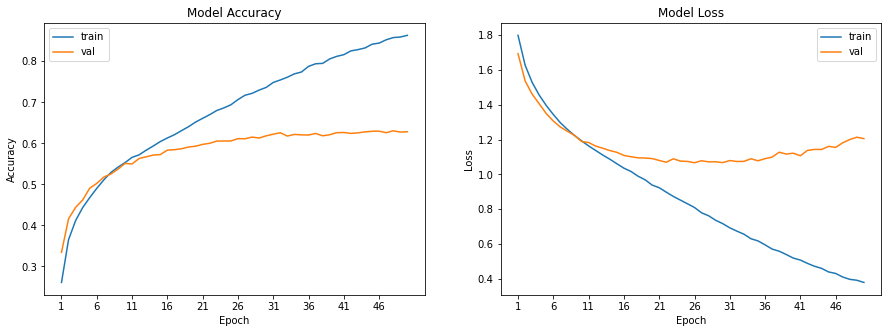

In [26]:
plot_model_history(model_info)

In [27]:
model.save_weights('model.h5')

In [35]:
import cv2

model.load_weights('model.h5')

    # prevents openCL usage and unnecessary logging messages
cv2.ocl.setUseOpenCL(False)

    # dictionary which assigns each label an emotion (alphabetical order)
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Neutral", 5: "Sad", 6: "Surprised"}

    # start the webcam feed
cap = cv2.VideoCapture(0)
while True:
        # Find haar cascade to draw bounding box around face
    ret, frame = cap.read()
    if not ret:
        break
    facecasc = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = facecasc.detectMultiScale(gray,scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        cv2.rectangle(frame, (x, y-50), (x+w, y+h+10), (255, 0, 0), 2)
        roi_gray = gray[y:y + h, x:x + w]
        cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
        prediction = model.predict(cropped_img)
        maxindex = int(np.argmax(prediction))
        cv2.putText(frame, emotion_dict[maxindex], (x+20, y-60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)

    cv2.imshow('Video', cv2.resize(frame,(1600,960),interpolation = cv2.INTER_CUBIC))
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 21ms/step


QObject::moveToThread: Current thread (0x55804d728e60) is not the object's thread (0x55804d104970).
Cannot move to target thread (0x55804d728e60)

QObject::moveToThread: Current thread (0x55804d728e60) is not the object's thread (0x55804d104970).
Cannot move to target thread (0x55804d728e60)

QObject::moveToThread: Current thread (0x55804d728e60) is not the object's thread (0x55804d104970).
Cannot move to target thread (0x55804d728e60)

QObject::moveToThread: Current thread (0x55804d728e60) is not the object's thread (0x55804d104970).
Cannot move to target thread (0x55804d728e60)

QObject::moveToThread: Current thread (0x55804d728e60) is not the object's thread (0x55804d104970).
Cannot move to target thread (0x55804d728e60)

QObject::moveToThread: Current thread (0x55804d728e60) is not the object's thread (0x55804d104970).
Cannot move to target thread (0x55804d728e60)

QObject::moveToThread: Current thread (0x55804d728e60) is not the object's thread (0x55804d104970).
Cannot move to tar

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - 0s 17ms/step
